In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [21]:
import cv2
import os

images = []
labels=[]

# Load in the images
for filepath in os.listdir('../DCGAN/data/infiltration/1/'):
    images.append(cv2.imread('../DCGAN/data/infiltration/1/{0}'.format(filepath),0))
    labels.append(0)
for filepath in os.listdir('../DCGAN/data/effusion/1/'):
    images.append(cv2.imread('../DCGAN/data/effusion/1/{0}'.format(filepath),0))
    labels.append(1)
for filepath in os.listdir('../DCGAN/data/atel/1/'):
    images.append(cv2.imread('../DCGAN/data/atel/1/{0}'.format(filepath),0))
    labels.append(2)

np.save('images', images)
np.save('labels', labels)

In [2]:
images=np.load('images.npy')
labels=np.load('labels.npy')

In [3]:
class chestxray(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.labels = labels
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [5]:
normalize = transforms.Normalize(mean=[0.456], std=[0.225])
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(256), transforms.ToTensor(), normalize])
dataset = chestxray(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = 1
        self.label_emb = nn.Embedding(256, 256)
        self.main = nn.Sequential(
            # input is (nc+1) x 256 x 256
            nn.Conv2d(nc+1, int(ndf/2) , 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf/2) x 128 x 128
            nn.Conv2d(int(ndf/2), ndf, 4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )
    def forward(self, input, labels):
        c = self.label_emb(labels)
        c = c.view(c.shape[0], 1, c.shape[1])
        c = c.repeat(1, 256, 1)
        c = c.view(c.shape[0], 1, c.shape[1], c.shape[2])
        x = torch.cat([input, c], 1)
        return self.main(x)

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = 1
        self.label_emb = nn.Embedding(3,3)
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz + 3, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      int(ngf/2) , 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(ngf/2)),
            nn.ReLU(True),
            # state size. (ngf/2) x 128 x 128
            nn.ConvTranspose2d(    int(ngf/2) ,   nc , 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256
        )

    def forward(self, input, labels):
        z = input.view(input.size(0), nz, 1, 1)
        c = self.label_emb(labels).view(input.size(0), 3, 1, 1)
        x = torch.cat([z, c], 1)
        return self.main(x)

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (label_emb): Embedding(3, 3)
  (main): Sequential(
    (0): ConvTranspose2d(131, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (label_emb): Embedding(256, 256)
  (main): Sequential(
    (0): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512,

In [9]:
netG = Generator(ngpu)
netG.load_state_dict(torch.load("generator_model",map_location="cuda:0"))
netG.to(device)
netD = Discriminator(ngpu)
netD.load_state_dict(torch.load("discriminator_model",map_location="cuda:0"))
netD.to(device)

Discriminator(
  (label_emb): Embedding(256, 256)
  (main): Sequential(
    (0): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512,

In [10]:
import torch.optim as optim
import random
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = random.uniform(0, 0.25)
fake_label = random.uniform(0.75, 1)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, labels) in enumerate(data_loader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu, labels.to(device)).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = Variable(torch.randn(b_size, nz, 1, 1)).cuda()
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 3, b_size))).cuda()
        # Generate fake image batch with G
        fake = netG(noise, fake_labels)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), fake_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, fake_labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

      #  while(errG - errD > 7):
       #     print("in the loop")
        #    netG.zero_grad()
         #   label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
        #    output = netD(fake, fake_labels).view(-1)
            # Calculate G's loss based on this output
        #    errG = criterion(output, label)
            # Calculate gradients for G
        #    errG.backward(retain_graph=True)
        #    D_G_z2 = output.mean().item()
            # Update G
        #    optimizerG.step()
            # Output training stats

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
     #   if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
     #       with torch.no_grad():
     #           fake = netG(fixed_noise).detach().cpu()
      #      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    torch.save(netG.state_dict(), "generator_model")
    torch.save(netD.state_dict(), "discriminator_model")

Starting Training Loop...
[0/50000][0/558]	Loss_D: 0.9860	Loss_G: 2.2535	D(x): 0.0495	D(G(z)): 0.9647 / 0.9099
[0/50000][50/558]	Loss_D: 0.7711	Loss_G: 1.4658	D(x): 0.0752	D(G(z)): 0.7911 / 0.7905
[0/50000][100/558]	Loss_D: 0.7712	Loss_G: 1.5318	D(x): 0.0717	D(G(z)): 0.8001 / 0.8051
[0/50000][150/558]	Loss_D: 0.7715	Loss_G: 1.4117	D(x): 0.0770	D(G(z)): 0.8046 / 0.7776
[0/50000][200/558]	Loss_D: 0.7724	Loss_G: 1.5530	D(x): 0.0656	D(G(z)): 0.7763 / 0.8096
[0/50000][250/558]	Loss_D: 0.7717	Loss_G: 1.4997	D(x): 0.0766	D(G(z)): 0.8010 / 0.7981
[0/50000][300/558]	Loss_D: 0.7714	Loss_G: 1.4561	D(x): 0.0693	D(G(z)): 0.8028 / 0.7881
[0/50000][350/558]	Loss_D: 0.7721	Loss_G: 1.3973	D(x): 0.0798	D(G(z)): 0.8066 / 0.7738
[0/50000][400/558]	Loss_D: 0.7865	Loss_G: 1.8800	D(x): 0.0596	D(G(z)): 0.7252 / 0.8626
[0/50000][450/558]	Loss_D: 0.7713	Loss_G: 1.5189	D(x): 0.0754	D(G(z)): 0.7866 / 0.8023
[0/50000][500/558]	Loss_D: 0.7710	Loss_G: 1.4826	D(x): 0.0733	D(G(z)): 0.7940 / 0.7943
[0/50000][550/558]	L

In [11]:
noise = Variable(torch.randn(64, nz, 1, 1)).cuda()
fake_labels = Variable(torch.LongTensor(np.random.randint(0, 3, 64))).cuda()
fake = netG(noise, fake_labels)

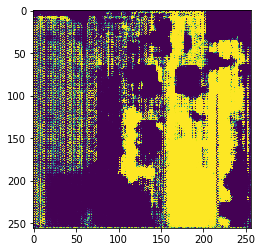

In [16]:
plt.imshow(fake[10, 0,:,:].detach().cpu())

In [13]:
fake.shape

torch.Size([64, 1, 256, 256])